# Data Wrangling Project (We Rate Dogs)

## Importing Required Libraries

In [218]:
import pandas as pd
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import dates
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import os

## Gathering Phase

In [219]:
# Loading the provided twitter archive data sets into dataframe

df_twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

In [220]:
# Downloading the image prediction tsv file and load it into another dataframe,
# if an exception occurred during the downloading phase, we will go to use an offline version

if not os.path.isfile('image-predictions.tsv'):
    try:
        url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
        tsv = requests.get(url, allow_redirects=True)
        open('image-predictions.tsv', 'wb').write(tsv.content)
        df_image_predictions = pd.read_csv('image-predictions.tsv', '\t', engine='python')
    except:
        df_image_predictions = pd.read_csv('image-predictions-offline.tsv', '\t', engine='python')
else:
    df_image_predictions = pd.read_csv('image-predictions.tsv', '\t', engine='python')

In [221]:
# Getting Tweets metadata using Tweeter Search APIs 

if not os.path.isfile('tweet_json.txt'):    
    consumer_key = 'P9GBS4afNlDrXuF6oy1PbxUab'
    consumer_secret = 'CaHoSKeTecyKNhnmbqVHH6vPu8Mqg0plinNmPYuerDktWLhIyM'
    access_token = '523273276-eFqsZJX3zc6udeBFN46WYtquvrLqnMow2ouHpoIl'
    access_secret = 't1lsf2FmX4zaGFSnv66Bl4SOKP0xBw83F0ly3UVBxBMkn'

    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)

    api = tweepy.API(auth, wait_on_rate_limit=True)

    tweet_ids = df_twitter_archive.tweet_id.values
    len(tweet_ids)

    # Query Twitter's API for JSON data for each tweet ID in the Twitter archive
    count = 0
    fails_dict = {}
    start = timer()
    # Save each tweet's returned JSON as a new line in a .txt file
    with open('tweet_json.txt', 'w') as outfile:
        # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
        for tweet_id in tweet_ids:
            count += 1
            print(str(count) + ": " + str(tweet_id))
            try:
                tweet = api.get_status(tweet_id, tweet_mode='extended')
                print("Success")
                json.dump(tweet._json, outfile)
                outfile.write('\n')
            except tweepy.TweepError as e:
                print("Fail")
                fails_dict[tweet_id] = e
                pass
    end = timer()
    print(end - start)
    print(fails_dict)

In [222]:
# Parsing the retrieved Tweets json API data

tweets_list=[]
try:
    with open('tweet_json.txt','r') as json_file:
        for line in json_file:
            tweet_txt = json.loads(line)
            tweet_dict = {'tweet_id':tweet_txt['id'],'retweet_count':tweet_txt['retweet_count'],'favorite_count':tweet_txt['favorite_count']}
            tweets_list.append(tweet_dict)
except:
    with open('tweet_json_offline.txt','r') as json_file:
        for line in json_file:
            tweet_txt = json.loads(line)
            tweet_dict = {'tweet_id':tweet_txt['id'],'retweet_count':tweet_txt['retweet_count'],'favorite_count':tweet_txt['favorite_count']}
            tweets_list.append(tweet_dict)   
            
df_retweets_counts = pd.DataFrame(tweets_list)

# persist the parsed API data into CSV file
df_retweets_counts.to_csv('tweets-counts.csv')

## Assessing Phase

In [223]:
df_twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [224]:
df_twitter_archive.tail()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


In [225]:
sum(df_twitter_archive.expanded_urls.notnull())

2297

In [226]:
df_twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [227]:
df_twitter_archive.query('in_reply_to_status_id != "NaN"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2038,671550332464455680,6.715449e+17,4.196984e+09,2015-12-01 04:44:10 +0000,"<a href=""http://twitter.com/download/iphone"" r...",After 22 minutes of careful deliberation this ...,NaN,NaN,NaN,NaN,1,10,None,None,None,None,None
2149,669684865554620416,6.693544e+17,4.196984e+09,2015-11-26 01:11:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",After countless hours of research and hundreds...,NaN,NaN,NaN,NaN,11,10,None,None,None,None,None
2169,669353438988365824,6.678065e+17,4.196984e+09,2015-11-25 03:14:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tessa. She is also very pleased after ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669353438...,10,10,Tessa,None,None,None,None
2189,668967877119254528,6.689207e+17,2.143566e+07,2015-11-24 01:42:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",12/10 good shit Bubka\n@wane15,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None


In [228]:
df_twitter_archive.query('retweeted_status_id != "NaN"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023,746521445350707200,NaN,NaN,2016-06-25 01:52:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Shaggy. He knows exactl...,6.678667e+17,4.196984e+09,2015-11-21 00:46:50 +0000,https://twitter.com/dog_rates/status/667866724...,10,10,Shaggy,None,None,None,None
1043,743835915802583040,NaN,NaN,2016-06-17 16:01:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Extremely intelligent dog here....,6.671383e+17,4.196984e+09,2015-11-19 00:32:12 +0000,https://twitter.com/dog_rates/status/667138269...,10,10,None,None,None,None,None
1242,711998809858043904,NaN,NaN,2016-03-21 19:31:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @twitter: @dog_rates Awesome Tweet! 12/10. ...,7.119983e+17,7.832140e+05,2016-03-21 19:29:52 +0000,https://twitter.com/twitter/status/71199827977...,12,10,None,None,None,None,None
2259,667550904950915073,NaN,NaN,2015-11-20 03:51:52 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",RT @dogratingrating: Exceptional talent. Origi...,6.675487e+17,4.296832e+09,2015-11-20 03:43:06 +0000,https://twitter.com/dogratingrating/status/667...,12,10,None,None,None,None,None


In [229]:
sum(df_twitter_archive.expanded_urls.isnull())

59

In [230]:
df_twitter_archive.expanded_urls.sort_values()

1265    http://goo.gl/ArWZfi,https://twitter.com/dog_r...
444     http://us.blastingnews.com/news/2017/01/200-do...
391     http://us.blastingnews.com/news/2017/01/kentuc...
335     http://us.blastingnews.com/news/2017/02/jfk-an...
204     http://www.gofundme.com/bluethewhitehusky,http...
                              ...                        
1940                                                  NaN
2038                                                  NaN
2149                                                  NaN
2189                                                  NaN
2298                                                  NaN
Name: expanded_urls, Length: 2356, dtype: object

In [231]:
df_twitter_archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [232]:
df_twitter_archive.name.value_counts()

None       745
a           55
Charlie     12
Oliver      11
Lucy        11
          ... 
Stewie       1
Coleman      1
Iggy         1
Hanz         1
all          1
Name: name, Length: 957, dtype: int64

In [233]:
df_twitter_archive.query('name =="a" | name =="an" | name=="None"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
12,889665388333682689,NaN,NaN,2017-07-25 01:55:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a puppo that seems to be on the fence a...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/889665388...,13,10,None,None,None,None,puppo
24,887343217045368832,NaN,NaN,2017-07-18 16:08:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",You may not have known you needed to see this ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887343217...,13,10,None,None,None,None,None
25,887101392804085760,NaN,NaN,2017-07-18 00:07:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This... is a Jubilant Antarctic House Bear. We...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887101392...,12,10,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [234]:
df_twitter_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [235]:
df_twitter_archive.query('rating_numerator < 10')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
45,883482846933004288,NaN,NaN,2017-07-08 00:28:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bella. She hopes her smile made you sm...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/883482846...,5,10,Bella,None,None,None,None
229,848212111729840128,NaN,NaN,2017-04-01 16:35:01 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Jerry. He's doing a distinguished tong...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/848212111...,6,10,Jerry,None,None,None,None
315,835152434251116546,NaN,NaN,2017-02-24 15:40:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you're so blinded by your systematic plag...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/835152434...,0,10,None,None,None,None,None
387,826598799820865537,8.265984e+17,4.196984e+09,2017-02-01 01:11:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...","I was going to do 007/10, but the joke wasn't ...",NaN,NaN,NaN,NaN,7,10,None,None,None,None,None
462,817502432452313088,NaN,NaN,2017-01-06 22:45:43 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Herschel. He's slightly bi...,6.924173e+17,4.196984e+09,2016-01-27 18:42:06 +0000,https://twitter.com/dog_rates/status/692417313...,7,10,Herschel,None,None,pupper,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [236]:
df_twitter_archive.rating_denominator.sort_values()

313       0
2335      2
516       7
1576     10
1575     10
       ... 
1635    110
1779    120
1634    130
902     150
1120    170
Name: rating_denominator, Length: 2356, dtype: int64

In [237]:
df_twitter_archive.query('rating_denominator != 10')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
342,832088576586297345,8.320875e+17,3.058208e+07,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023...,204,170,this,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582...,4,20,None,None,None,None,None
1202,716439118184652801,NaN,NaN,2016-04-03 01:36:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,None,None,None,None


In [238]:
df_twitter_archive.doggo.value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [239]:
df_twitter_archive.floofer.value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [240]:
df_twitter_archive.puppo.value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

In [241]:
df_twitter_archive.pupper.value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [149]:
sum(df_twitter_archive.duplicated())

0

In [243]:
rating_df = df_twitter_archive.copy()

rating_df['rating'] = rating_df.rating_numerator.astype(str) + "/" + rating_df.rating_denominator.astype(str) 
rating_df = rating_df[rating_df.apply(lambda x: x.rating not in x.text, axis=1)]
print(rating_df.info())
# it seems that the rating extraction is correct!!!, but the values have some outlier or exceptions

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    0 non-null      int64  
 1   in_reply_to_status_id       0 non-null      float64
 2   in_reply_to_user_id         0 non-null      float64
 3   timestamp                   0 non-null      object 
 4   source                      0 non-null      object 
 5   text                        0 non-null      object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               0 non-null      object 
 10  rating_numerator            0 non-null      int64  
 11  rating_denominator          0 non-null      int64  
 12  name                        0 non-null      object 
 13  doggo                       0 non-null      obj

In [244]:
df_image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [245]:
df_image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [246]:
df_image_predictions.p1.value_counts()

golden_retriever      150
Labrador_retriever    100
Pembroke               89
Chihuahua              83
pug                    57
                     ... 
candle                  1
espresso                1
bearskin                1
convertible             1
polecat                 1
Name: p1, Length: 378, dtype: int64

In [247]:
df_image_predictions.p1.sort_values()

1561         Afghan_hound
1855         Afghan_hound
1458         Afghan_hound
1804         Afghan_hound
446     African_crocodile
              ...        
253           wood_rabbit
1831         wooden_spoon
932                  wool
246                  wool
297                 zebra
Name: p1, Length: 2075, dtype: object

In [248]:
df_image_predictions.query('p1_dog == False & p2_dog == False & p3_dog == False')

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
17,666104133288665088,https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg,1,hen,0.965932,False,cock,0.033919,False,partridge,0.000052,False
18,666268910803644416,https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg,1,desktop_computer,0.086502,False,desk,0.085547,False,bookcase,0.079480,False
21,666293911632134144,https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg,1,three-toed_sloth,0.914671,False,otter,0.015250,False,great_grey_owl,0.013207,False
25,666362758909284353,https://pbs.twimg.com/media/CT9lXGsUcAAyUFt.jpg,1,guinea_pig,0.996496,False,skunk,0.002402,False,hamster,0.000461,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2021,880935762899988482,https://pbs.twimg.com/media/DDm2Z5aXUAEDS2u.jpg,1,street_sign,0.251801,False,umbrella,0.115123,False,traffic_light,0.069534,False
2022,881268444196462592,https://pbs.twimg.com/media/DDrk-f9WAAI-WQv.jpg,1,tusker,0.473303,False,Indian_elephant,0.245646,False,ibex,0.055661,False
2046,886680336477933568,https://pbs.twimg.com/media/DE4fEDzWAAAyHMM.jpg,1,convertible,0.738995,False,sports_car,0.139952,False,car_wheel,0.044173,False
2052,887517139158093824,https://pbs.twimg.com/ext_tw_video_thumb/88751...,1,limousine,0.130432,False,tow_truck,0.029175,False,shopping_cart,0.026321,False


In [249]:
df_image_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [250]:
df_image_predictions.query('p2_conf > p1_conf | p3_conf > p1_conf')

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [251]:
df_retweets_counts.head(-5)

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7651,35962
1,892177421306343426,5649,31035
2,891815181378084864,3747,23356
3,891689557279858688,7815,39263
4,891327558926688256,8410,37503
...,...,...,...
2321,666058600524156928,53,105
2322,666057090499244032,124,268
2323,666055525042405380,219,406
2324,666051853826850816,771,1119


In [252]:
df_retweets_counts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2331 non-null   int64
 1   retweet_count   2331 non-null   int64
 2   favorite_count  2331 non-null   int64
dtypes: int64(3)
memory usage: 54.8 KB


### Quality Issues (Completeness, Validity, Accuracy, Consistency)

#### twitter_archive

- timestamp column is object not date
- day of week and hour of day are important for that data set and need to be extracted
- there are rating_numerator have value < 10
- there are rating_denominator have value != 10
- invalid rows, which has no dog images
- invalid rows, which are retweeted and not original tweets
- invalid rows, which are replies to orginal tweets
- retweeted_status_id is flost not int
- there are None values not NaN/False
- dogs are named with 'a' or 'an.


#### image_preddication

- p1,p2,p3 shall be category not object
- there is none predicted dog values and shall be removed 


#### retweet count

- nothing, as its gathered in a good quality manner


### Tidiness Issues (Structural)

- useless columns: source, in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id	retweeted_status_user_id	  retweeted_status_timestamp
- dog stages not well structured ,shall be one column
    - but the it will yeild very small data set as the detected stages are not too much
- image prediction p1,p2,p2 we shall keep the highiest one with dog as true

## Clean

#### Define

##### Missing Data Fixing
- nothing to complete, no extra data needed

##### Removing invalid Data 
- remove from twiter archive where retweeted_status_id is not NaN
- remove from twiter archive where in_reply_to_status_id is not NaN
- remove from twiter archive where expanded_urls is NaN
- remove from image prediection where the all dog predication are false
-- remove rows that has inconsist rating, numerator less than 10 and denominator not equal to 10
- remove columns (source, in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id retweeted_status_user_id retweeted_status_timestamp)

##### Tidiness Fixing
- twitter archive data set
    - melt dog stages (to be one column)
- image predeiction data set
    - melt P columns to be one P which has the highest conf value and dog type is Ture
        - make addtional P column firstly that statify the above criteria, then remove all (P, Conf, is dog)
- merge twitter archieve with image prediction and tweets counta

##### Remaining Qulity Issues
- convert timestamp to datetime
- add addtional feilds from timestamp(day of week, hour)
- convert None values to NaN for all columns
- convert a or an as dog name to NaN
- convert dog breed to category


#### Code

In [253]:
#take copyies from the orginal data sets

df_image_predictions_clean = df_image_predictions.copy()
df_twitter_archive_clean = df_twitter_archive.copy()
df_retweets_counts_clean = df_retweets_counts.copy()

In [254]:
#removing invalid rows

df_twitter_archive_clean.drop(df_twitter_archive_clean.query('retweeted_status_id != "NaN"').index, axis=0, inplace=True)
df_twitter_archive_clean.drop(df_twitter_archive_clean.query('in_reply_to_status_id != "NaN"').index, axis=0, inplace=True)
df_twitter_archive_clean.dropna(subset=['expanded_urls'],inplace=True)

In [255]:
#solving tidiness issues for twitter archievice data set

df_twitter_archive_clean = df_twitter_archive_clean.drop(['source','in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp'], axis=1)

In [256]:
#solving tidiness issues for image prediction data set

def aggregate_p(row):
    if row['p1_dog'] == True:
        row['dog_breed'] = row['p1']
        row['dog_prob'] = row['p1_conf']
    elif row['p2_dog'] == True:
        row['dog_breed'] = row['p2']
        row['dog_prob'] = row['p2_conf']
    elif row['p3_dog'] == True:
        row['dog_breed'] = row['p3']
        row['dog_prob'] = row['p3_conf']
    else:
        row['dog_breed'] = np.nan
        row['dog_prob'] = np.nan
    return row

df_image_predictions_clean = df_image_predictions_clean.apply(aggregate_p , axis=1)
df_image_predictions_clean = df_image_predictions_clean.drop(['p1','p1_conf','p1_dog','p2','p2_conf','p2_dog','p3','p3_conf','p3_dog'], axis=1)

In [257]:
#merge twitter archive with tweets count and image predication

df_twitter_archive_clean_master = pd.merge(df_twitter_archive_clean, df_retweets_counts_clean, on=['tweet_id'], how='left')
df_twitter_archive_clean_master = pd.merge(df_twitter_archive_clean_master, df_image_predictions_clean, on=['tweet_id'], how='left')

In [258]:
# solve quality issues

df_twitter_archive_clean_master.timestamp = pd.to_datetime(df_twitter_archive_clean_master.timestamp)
df_twitter_archive_clean_master['day_of_week'] = df_twitter_archive_clean_master.timestamp.dt.day_name()
df_twitter_archive_clean_master['hour_of_day'] = df_twitter_archive_clean_master.timestamp.dt.hour

df_twitter_archive_clean_master = df_twitter_archive_clean_master.replace('None', np.nan)
df_twitter_archive_clean_master.name.fillna('a', inplace=True)
df_twitter_archive_clean_master.name.fillna('an', inplace=True)

df_twitter_archive_clean_master = df_twitter_archive_clean_master[df_twitter_archive_clean_master['dog_breed'].notna()]
df_twitter_archive_clean_master.dog_breed = df_twitter_archive_clean_master.dog_breed.astype('category')

df_twitter_archive_clean_master.to_csv('twitter_archive_master.csv', index=False)


In [259]:
# take addtional tidiness actions related to the final and merged data sets with consist rating numbers and dog stages
# save this as addtional cleaned option
df_twitter_archive_clean_more_tidy = pd.melt(df_twitter_archive_clean_master, id_vars=['tweet_id','timestamp','text','expanded_urls','rating_numerator','rating_denominator','name','retweet_count','favorite_count','jpg_url','img_num','dog_breed','dog_prob','day_of_week','hour_of_day'],var_name='dog_stage',value_name='stage_confirmation')
df_twitter_archive_clean_more_tidy = df_twitter_archive_clean_more_tidy[df_twitter_archive_clean_more_tidy['stage_confirmation'].notna()]
df_twitter_archive_clean_more_tidy.drop(df_twitter_archive_clean_more_tidy.query('rating_denominator != 10').index, axis=0, inplace=True)
df_twitter_archive_clean_more_tidy = df_twitter_archive_clean_more_tidy.drop(['stage_confirmation'],axis=1)
df_twitter_archive_clean_more_tidy.dog_stage = df_twitter_archive_clean_more_tidy.dog_stage.astype('category')
df_twitter_archive_clean_more_tidy.to_csv('twitter_archive_master_more_tidiy.csv', index=False)


#### Test

In [260]:
sum(df_twitter_archive_clean_more_tidy.dog_breed.isna())

0

In [261]:
df_twitter_archive_clean_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1666 entries, 1 to 2093
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1666 non-null   int64              
 1   timestamp           1666 non-null   datetime64[ns, UTC]
 2   text                1666 non-null   object             
 3   expanded_urls       1666 non-null   object             
 4   rating_numerator    1666 non-null   int64              
 5   rating_denominator  1666 non-null   int64              
 6   name                1666 non-null   object             
 7   doggo               63 non-null     object             
 8   floofer             8 non-null      object             
 9   pupper              173 non-null    object             
 10  puppo               22 non-null     object             
 11  retweet_count       1659 non-null   float64            
 12  favorite_count      1659 non-null 

In [262]:
df_twitter_archive_clean_more_tidy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 266 entries, 8 to 5715
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            266 non-null    int64              
 1   timestamp           266 non-null    datetime64[ns, UTC]
 2   text                266 non-null    object             
 3   expanded_urls       266 non-null    object             
 4   rating_numerator    266 non-null    int64              
 5   rating_denominator  266 non-null    int64              
 6   name                266 non-null    object             
 7   retweet_count       265 non-null    float64            
 8   favorite_count      265 non-null    float64            
 9   jpg_url             266 non-null    object             
 10  img_num             266 non-null    float64            
 11  dog_breed           266 non-null    category           
 12  dog_prob            266 non-null   

In [263]:
df_twitter_archive_clean.head()

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27 +0000,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03 +0000,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51 +0000,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24 +0000,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [264]:
df_twitter_archive_clean.head()

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27 +0000,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03 +0000,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51 +0000,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24 +0000,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [265]:
df_twitter_archive_clean_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1666 entries, 1 to 2093
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1666 non-null   int64              
 1   timestamp           1666 non-null   datetime64[ns, UTC]
 2   text                1666 non-null   object             
 3   expanded_urls       1666 non-null   object             
 4   rating_numerator    1666 non-null   int64              
 5   rating_denominator  1666 non-null   int64              
 6   name                1666 non-null   object             
 7   doggo               63 non-null     object             
 8   floofer             8 non-null      object             
 9   pupper              173 non-null    object             
 10  puppo               22 non-null     object             
 11  retweet_count       1659 non-null   float64            
 12  favorite_count      1659 non-null 

In [266]:
df_twitter_archive_clean_master.select_dtypes(include=[np.float64,np.int64])

,tweet_id,rating_numerator,rating_denominator,retweet_count,favorite_count,img_num,dog_prob,hour_of_day
1,892177421306343426,13,10,5649.0,31035.0,1.0,0.323581,0
2,891815181378084864,12,10,3747.0,23356.0,1.0,0.716012,0
3,891689557279858688,13,10,7815.0,39263.0,1.0,0.168086,15
4,891327558926688256,12,10,8410.0,37503.0,2.0,0.555712,16
5,891087950875897856,13,10,2819.0,18889.0,1.0,0.425595,0
...,...,...,...,...,...,...,...,...
2089,666049248165822465,5,10,40.0,96.0,1.0,0.560311,0
2090,666044226329800704,6,10,130.0,270.0,1.0,0.408143,0
2091,666033412701032449,9,10,41.0,112.0,1.0,0.596461,23
2092,666029285002620928,7,10,42.0,120.0,1.0,0.506826,23


In [267]:
df_twitter_archive_clean_master.select_dtypes(include=[np.float64,np.int64])

,tweet_id,rating_numerator,rating_denominator,retweet_count,favorite_count,img_num,dog_prob,hour_of_day
1,892177421306343426,13,10,5649.0,31035.0,1.0,0.323581,0
2,891815181378084864,12,10,3747.0,23356.0,1.0,0.716012,0
3,891689557279858688,13,10,7815.0,39263.0,1.0,0.168086,15
4,891327558926688256,12,10,8410.0,37503.0,2.0,0.555712,16
5,891087950875897856,13,10,2819.0,18889.0,1.0,0.425595,0
...,...,...,...,...,...,...,...,...
2089,666049248165822465,5,10,40.0,96.0,1.0,0.560311,0
2090,666044226329800704,6,10,130.0,270.0,1.0,0.408143,0
2091,666033412701032449,9,10,41.0,112.0,1.0,0.596461,23
2092,666029285002620928,7,10,42.0,120.0,1.0,0.506826,23


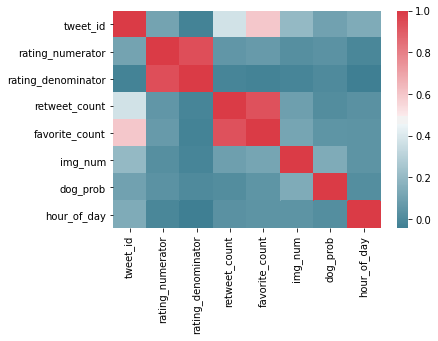

In [268]:
correlation = df_twitter_archive_clean_master.select_dtypes(include=[np.float64,np.int64]).corr()
sns.heatmap(correlation, xticklabels=correlation.columns, yticklabels=correlation.columns, cmap=sns.diverging_palette(220, 10, as_cmap=True))

<Figure size 1080x432 with 0 Axes>

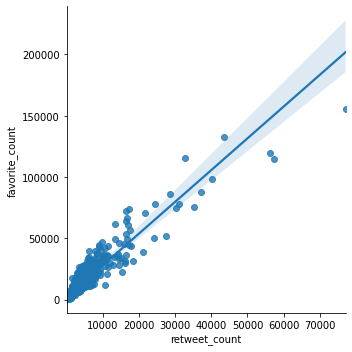

In [269]:
plt.figure(figsize=(15,6))
sns.lmplot(x='retweet_count', y='favorite_count', data=df_twitter_archive_clean_master)

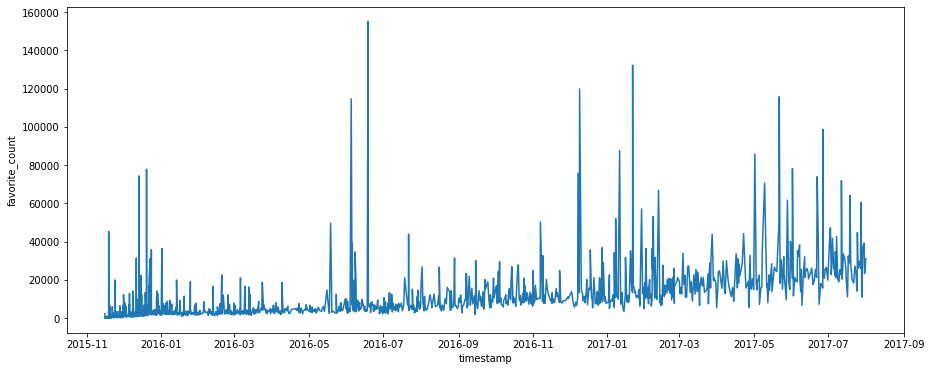

In [270]:
plt.figure(figsize=(15,6))
sns.lineplot(x='timestamp', y='favorite_count', data=df_twitter_archive_clean_master)

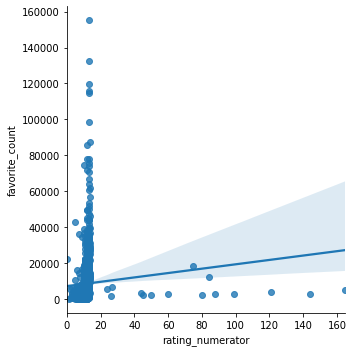

In [271]:
sns.lmplot(x='rating_numerator', y='favorite_count', data=df_twitter_archive_clean_master)

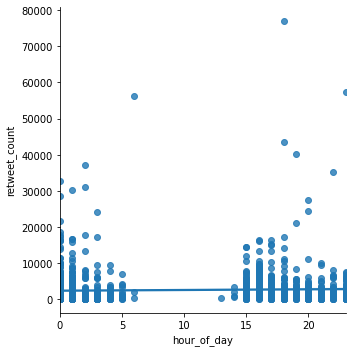

In [272]:
sns.lmplot(x='hour_of_day', y='retweet_count', data=df_twitter_archive_clean_master)

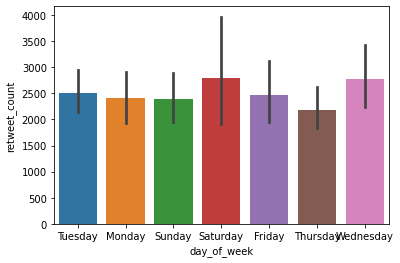

In [273]:
sns.barplot(x='day_of_week', y='retweet_count', data=df_twitter_archive_clean_master)

D:\Users\matef\Anaconda3\lib\site-packages\seaborn\categorical.py:1311: RuntimeWarning: invalid value encountered in less
  off_low = points < low_gutter
D:\Users\matef\Anaconda3\lib\site-packages\seaborn\categorical.py:1315: RuntimeWarning: invalid value encountered in greater
  off_high = points > high_gutter


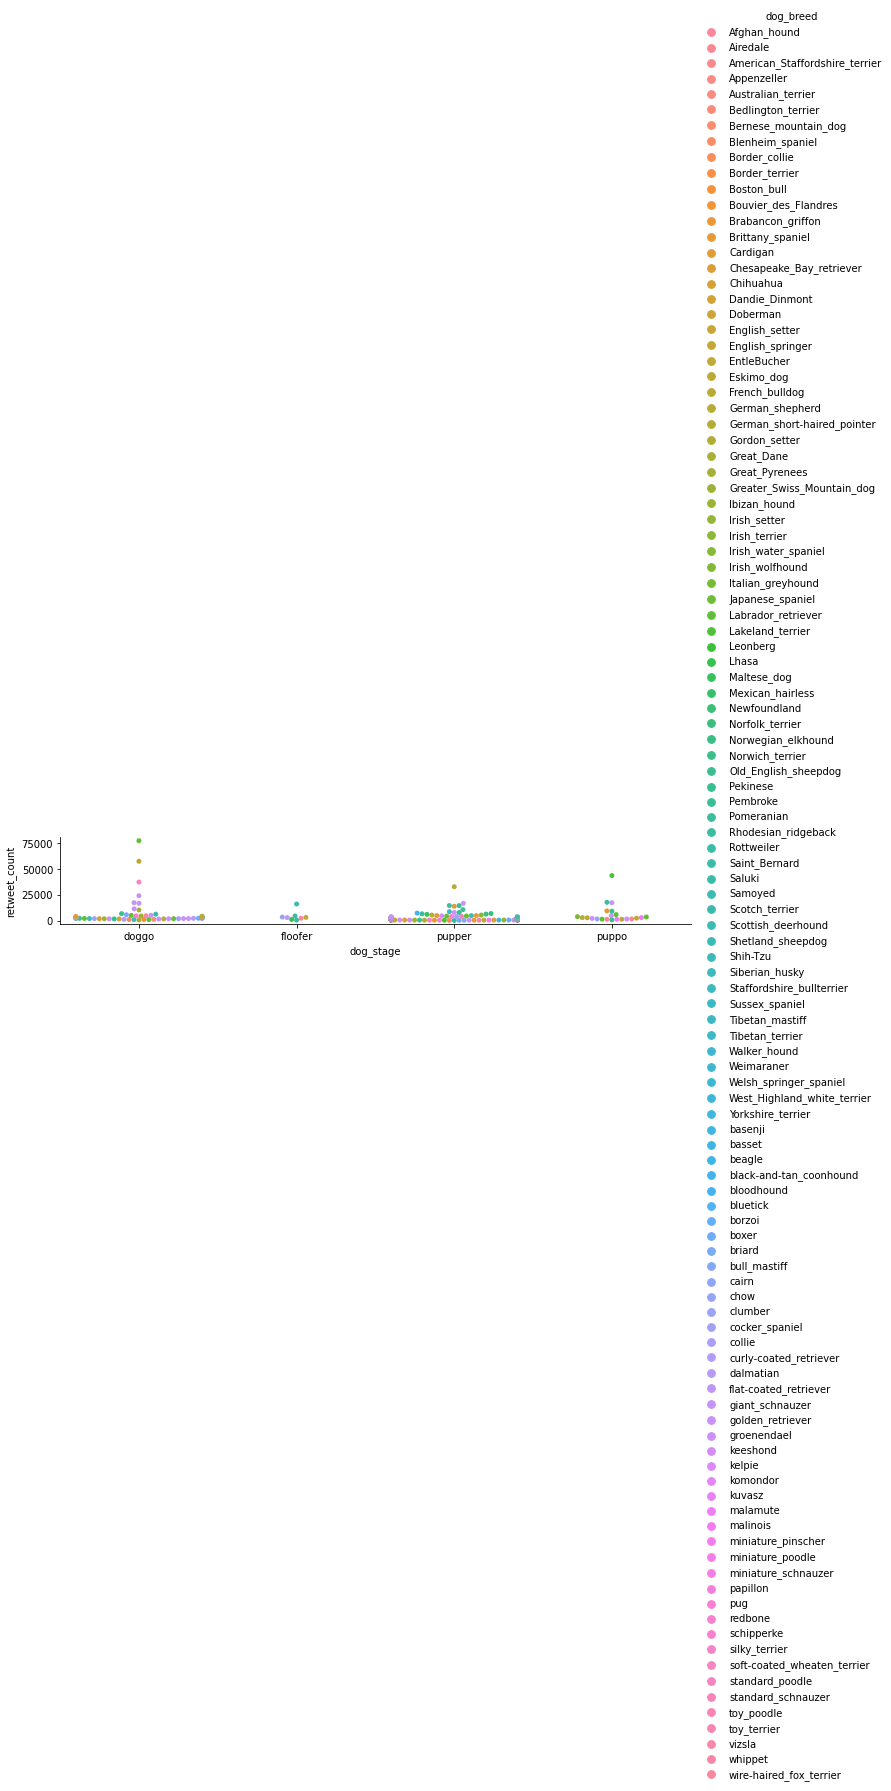

In [274]:
sns.catplot(x="dog_stage", y="retweet_count",hue='dog_breed',kind="swarm", height=2, aspect=5 ,data=df_twitter_archive_clean_more_tidy).savefig("output.png")

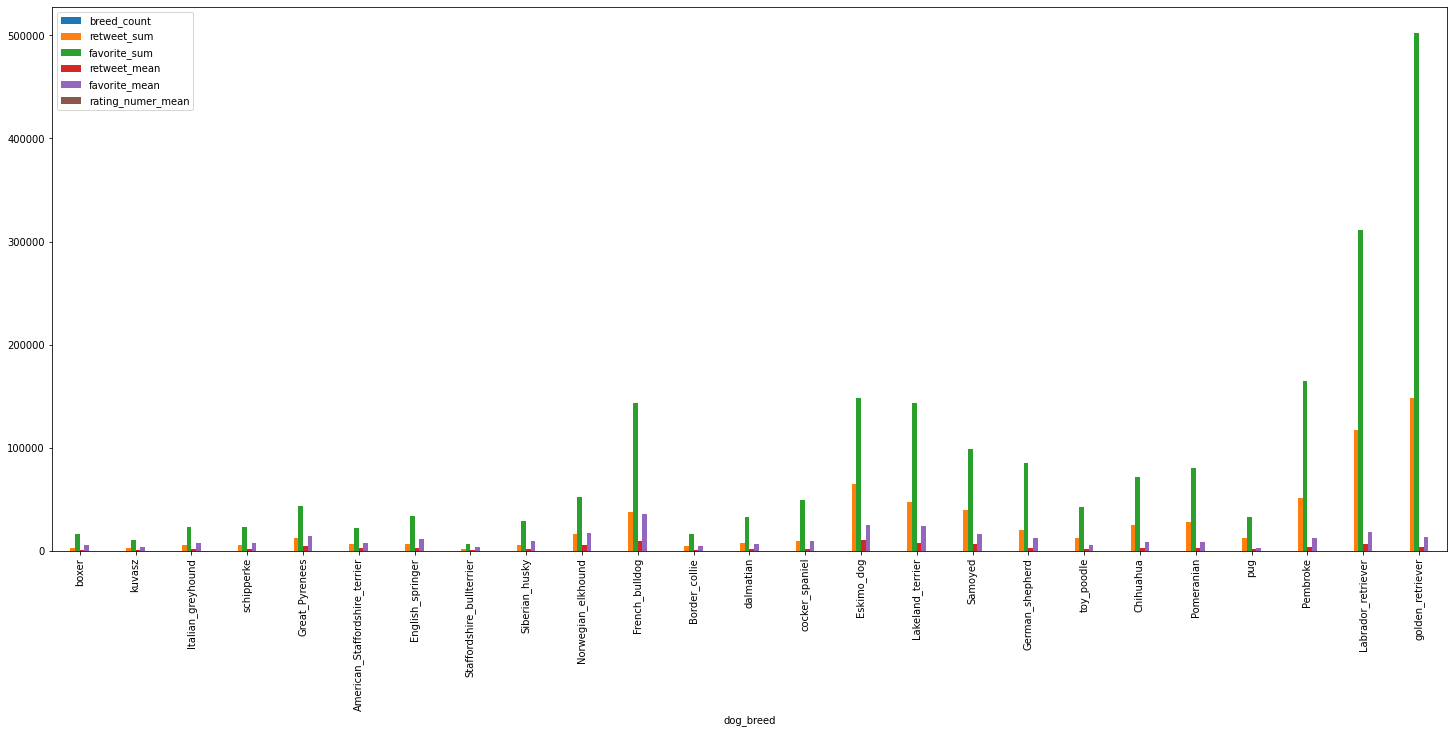

In [275]:
df_twitter_archive_clean_more_tidy.dog_breed.unique()

group_df = df_twitter_archive_clean_more_tidy
group_df.dog_breed = group_df.dog_breed.astype(str)

group_df=group_df.groupby('dog_breed').agg(
    breed_count = ('dog_breed', 'count'),
    retweet_sum = ('retweet_count', 'sum'),
    favorite_sum = ('favorite_count', 'sum'),
    retweet_mean = ('retweet_count', 'mean'),
    favorite_mean = ('favorite_count', 'mean'),
    rating_numer_mean = ('rating_numerator', 'mean')
    ,)

group_df = group_df.dropna()
group_df = group_df.sort_values(by=['breed_count']).tail(25)

group_df.plot(figsize=(25,10),kind='bar').figure.savefig('visulization.jpg')

#plt.show()

#group_df.reset_index(level=0, inplace=True)
#group_df.dog_breed = group_df.dog_breed.astype(str)
#plt.figure(figsize=(20,5))

#group_df = group_df.melt('dog_breed', var_name='summary',  value_name='vals')
#g = sns.catplot(x="dog_breed", y="vals", hue='summary',kind='strip', data=group_df)
#g.fig.set_figwidth(15.27)
#g.fig.set_figheight(5.7)